In [5]:
import os
import sys
import subprocess as subp
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import nibabel as nib

In [6]:
import collections
import multiprocessing 
import datetime

In [7]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [8]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [9]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [10]:
# Set path 
#path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_pheno = '/data/cisl/yassinebha/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno/'
path_root = '/data/cisl/yassinebha/scratch_pin/pleio/pleio_association/'
# Set file pattern
pedig_file_ptrn = 'solar_{}_spm_pedigre.csv'
pheno_file_ptrn = 'solar_{}_spm_{}_pheno.csv'
pheno_clust = os.path.join(path_pheno,'task_perform_select_norm.csv')
#pheno_clust = os.path.join(path_root,'hcp_bootstraped_pheno_nonan_norm_python_13.csv')
# Set task and trials
task_name = 'language'
nb_sbt= 5
list_sbt = ['sub%s' % str(i+1) for i in range(nb_sbt)]
list_trial = ['story']

In [11]:
list_sbt

['sub1', 'sub2', 'sub3', 'sub4', 'sub5']

In [12]:
# Load pedig file
pedig_df = pd.read_csv(os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))))

In [13]:
# Load subtypes weights
sbt_weight_df = pd.read_csv(os.path.join(path_root,'solar_{}_spm_{}_pheno.csv'.format(str.upper(task_name),
                                                                                 str(nb_sbt))))
sbt_weight_df.count()

ID                      778
LAN_story_sub1          778
LAN_story_sub2          778
LAN_story_sub3          778
LAN_story_sub4          778
LAN_story_sub5          778
Age_in_Yrs              778
Gender                  778
BMI                     778
LAN_FD_mean             778
LAN_FD_scrubbed_mean    778
dtype: int64

In [14]:
# Load phenotype clustered file
#pheno_clust_df = pd.read_csv(pheno_clust).rename(columns={'Subject': 'ID'})
pheno_clust_df = pd.read_csv(pheno_clust)
#pheno_clust_df.loc[:,'ID'] = 'HCP' + pheno_clust_df['ID'].astype(str)
pheno_clust_df.head()

,Subject,Emotion_Task_Acc,Emotion_Task_Median_RT,Gambling_Task_Median_RT_Larger,Language_Task_Acc,Language_Task_Median_RT,Relational_Task_Acc,Relational_Task_Median_RT,Social_Task_Random_Perc_Random,Social_Task_Random_Median_RT_Random,Social_Task_TOM_Perc_TOM,Social_Task_TOM_Median_RT_TOM,WM_Task_2bk_Acc,WM_Task_2bk_Median_RT,WM_Task_0bk_Acc,WM_Task_0bk_Median_RT
0,HCP100206,-0.786249,-0.961612,-0.842270,1.136412,-1.319090,-0.198650,-0.427552,-3.613889,-0.978018,0.475928,0.193927,-0.025941,-0.296939,0.848286,-1.059832
1,HCP100307,-0.691942,-1.354335,-1.013115,-1.239516,-0.343549,1.591281,0.140082,-0.324328,-0.856815,-1.199984,-1.558275,-0.638502,-0.708941,0.276491,-0.286743
2,HCP100408,0.815612,-0.271925,1.011337,1.186506,0.422845,0.331727,0.344895,-0.324328,0.844450,0.475928,1.067866,0.851421,0.718889,-0.054527,0.664662
3,HCP101006,-0.221086,-0.132051,0.566918,-0.778421,-0.531208,-1.822872,-0.694768,-0.324328,0.377349,-2.875895,1.941805,-2.393226,-2.370758,-0.385642,-0.490151
4,HCP101107,0.344417,-0.897055,-1.233091,-0.878609,2.017232,-1.756525,-2.007247,-0.324328,0.017615,0.475928,-0.270781,-0.638502,-1.055684,0.186248,-0.306524


In [16]:
# Clusters list
list_pheno_clust = [x for x in pheno_clust_df.columns.values if x!='Subject']
list_pheno_clust

['Emotion_Task_Acc',
 'Emotion_Task_Median_RT',
 'Gambling_Task_Median_RT_Larger',
 'Language_Task_Acc',
 'Language_Task_Median_RT',
 'Relational_Task_Acc',
 'Relational_Task_Median_RT',
 'Social_Task_Random_Perc_Random',
 'Social_Task_Random_Median_RT_Random',
 'Social_Task_TOM_Perc_TOM',
 'Social_Task_TOM_Median_RT_TOM',
 'WM_Task_2bk_Acc',
 'WM_Task_2bk_Median_RT',
 'WM_Task_0bk_Acc',
 'WM_Task_0bk_Median_RT']

In [17]:
# Merge pheno clusters with subtypes
sbt_pheno_df = pd.merge(sbt_weight_df,pheno_clust_df,how='left',left_on='ID',right_on='Subject')
sbt_pheno_df.dropna(inplace=True)

In [18]:
# check if any NaN value present
sbt_pheno_df.isnull().values.sum()

0

In [19]:
sbt_pheno_df.count()

ID                                     749
LAN_story_sub1                         749
LAN_story_sub2                         749
LAN_story_sub3                         749
LAN_story_sub4                         749
LAN_story_sub5                         749
Age_in_Yrs                             749
Gender                                 749
BMI                                    749
LAN_FD_mean                            749
LAN_FD_scrubbed_mean                   749
Subject                                749
Emotion_Task_Acc                       749
Emotion_Task_Median_RT                 749
Gambling_Task_Median_RT_Larger         749
Language_Task_Acc                      749
Language_Task_Median_RT                749
Relational_Task_Acc                    749
Relational_Task_Median_RT              749
Social_Task_Random_Perc_Random         749
Social_Task_Random_Median_RT_Random    749
Social_Task_TOM_Perc_TOM               749
Social_Task_TOM_Median_RT_TOM          749
WM_Task_2bk

### Pleiothropy estimate:

In [19]:
import collections
import multiprocessing 
import datetime

In [25]:
#initiate empty dictionary
Pleio_Asso = collections.namedtuple('Pleio_Asso', [
    'out_dir',
    'pedig_f',
    'pheno_f',
    'var_1',
    'var_2',
    'covar_1'
])
pleio_asso = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}_{}_tmp2'.format(str(datetime.date.today()),
                                                        task_name))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_trial, trial in enumerate(list_trial):
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            print(trial,clust,subt)
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name)[:3])
            
            # output result folder 
            path_pleio_contrast = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            if not os.path.exists(path_pleio_contrast):
                os.makedirs(path_pleio_contrast)
            
            # copy needed files to output folder
            if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
                subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
            if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_run.sh')):
                subp.run(['cp',os.path.join(path_root,'pleio_run.sh'),path_pleio_contrast])
        
            # pedegree
            if not os.path.isfile(os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))):
                subp.run(['cp',os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))),path_pleio_contrast]) 

            pedig_f = os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))

            # save pheno cov to file
            pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
            if not os.path.isfile(pheno_f):
                sbt_pheno_df[['ID','Age_in_Yrs','Gender',pheno_1,pheno_2,cov_1]].to_csv(pheno_f,index=False)   

            # collect all pleio contrasts in dictionary
            pleio_asso.append(Pleio_Asso(out_dir = path_pleio_contrast,
                                          pedig_f = pedig_f,
                                          pheno_f = pheno_f,
                                          var_1 = pheno_1,
                                          var_2 = pheno_2,
                                          covar_1 = cov_1)) 

story Emotion_Task_Acc sub1
story Emotion_Task_Acc sub2
story Emotion_Task_Acc sub3
story Emotion_Task_Acc sub4
story Emotion_Task_Acc sub5
story Emotion_Task_Median_RT sub1
story Emotion_Task_Median_RT sub2
story Emotion_Task_Median_RT sub3
story Emotion_Task_Median_RT sub4
story Emotion_Task_Median_RT sub5
story Gambling_Task_Median_RT_Larger sub1
story Gambling_Task_Median_RT_Larger sub2
story Gambling_Task_Median_RT_Larger sub3
story Gambling_Task_Median_RT_Larger sub4
story Gambling_Task_Median_RT_Larger sub5
story Language_Task_Acc sub1
story Language_Task_Acc sub2
story Language_Task_Acc sub3
story Language_Task_Acc sub4
story Language_Task_Acc sub5
story Language_Task_Median_RT sub1
story Language_Task_Median_RT sub2
story Language_Task_Median_RT sub3
story Language_Task_Median_RT sub4
story Language_Task_Median_RT sub5
story Relational_Task_Acc sub1
story Relational_Task_Acc sub2
story Relational_Task_Acc sub3
story Relational_Task_Acc sub4
story Relational_Task_Acc sub5
story

In [26]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2,
              x.covar_1,
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [27]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [28]:
result = parallel_process(pleio_asso,run_pleio,use_kwargs=False)

100%|██████████| 72.0/72.0 [00:47<00:00, 1.53it/s]
72it [00:00, 173557.41it/s]


In [29]:
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_asso)

In [30]:
#pool = multiprocessing.Pool()
#result = pool.map(run_pleio,pleio_asso)

In [24]:
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = True):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    # replace 0's by 1
    flatt[flatt == 0] =1
    fdr_1d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_1d = [-np.log10(ii) for ii in fdr_1d] 
    fdr_2d = np.reshape(fdr_1d,(row,col))
    return fdr_2d

In [25]:
dict_clusters = {'Emotion_Task_Acc' : 'EmoAcc',
                'Emotion_Task_Median_RT' : 'EmoRT',
                'Gambling_Task_Median_RT_Larger' : 'GamRT',
                'Language_Task_Acc' : 'LanAcc',
                'Language_Task_Median_RT' : 'LanRT',
                'Relational_Task_Acc' : 'RelAcc',
                'Relational_Task_Median_RT' : 'RelRT',
                'Social_Task_Random_Perc_Random' : 'SocRand',
                'Social_Task_Random_Median_RT_Random' : 'SocRRT',
                'Social_Task_TOM_Perc_TOM' : 'SocTOM',
                'Social_Task_TOM_Median_RT_TOM' : 'SocTRT',
                'WM_Task_2bk_Acc' : 'WM2bkAcc',
                'WM_Task_2bk_Median_RT' : 'WM2bkRT',
                'WM_Task_0bk_Acc' : 'WM0bkAcc',
                'WM_Task_0bk_Median_RT' : 'WM0bkRT'}

In [26]:
os.path.join(path_root,'pleio_{}_{}_tmp2'.format(str(datetime.date.today()),
                                                        task_name))

'/data/cisl/yassinebha/scratch_pin/pleio/pleio_association/pleio_2021-04-29_language_tmp2'

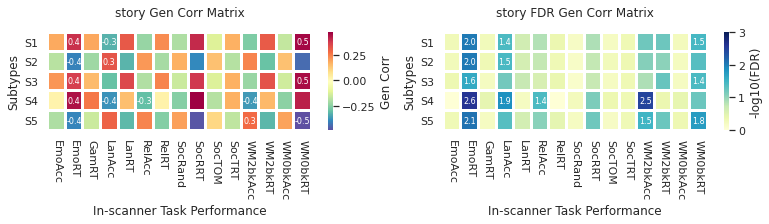

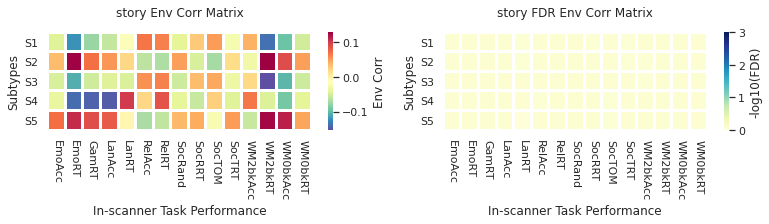

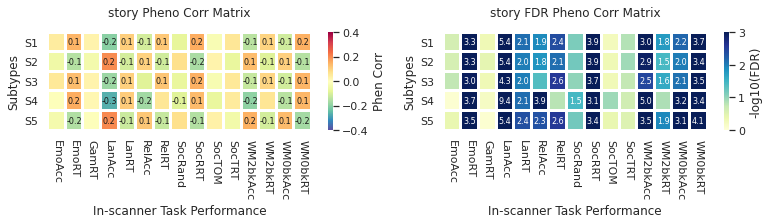

In [27]:
# Initiate no convergence result stack
path_pleio = os.path.join(path_root,'pleio_2019-07-24_language_tmp2')
No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'covar_1',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
H2r = dict()
# list subtype abreviation for figures only 
list_sbt_dict = {'sub1':'S1', 'sub2':'S2', 'sub3':'S3', 'sub4':'S4', 'sub5':'S5'}
list_sbt_ = [list_sbt_dict.get(item,item) for item in list_sbt ]

for ix_trial, trial in enumerate(list_trial):
    # initiate empty matrix
    RhoG = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_0 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_m1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
     
    # Loop over cluster
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name))
            
            # output result folder 
            out_dir = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            pedig_f = os.path.join(out_dir,pedig_file_ptrn.format(str.upper(task_name)))
            
            # pheno cov file
            pheno_f= os.path.join(out_dir,'pheno_cov.csv')
            # pedig file
            pedig_f = os.path.join(out_dir,'pleio_all_pheno_pedig.csv')
            
            #grab results from text file
            fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
            for i,line in enumerate(fp):
                if 'CONVERGENCE FAILURE' in line:
                    print(out_dir)
                    print(line)
                    count+=1
                    no_converges.append(No_converge(var_1 = pheno_1,
                                                    var_2 = pheno_2,
                                                    covar_1 = cov_1,
                                                    out_dir = out_dir,
                                                    pedig_f = pedig_f,
                                                    pheno_f = pedig_f))
                    break
                    
                    
                if 'H2r({}_norm) is '.format(pheno_1) in line:
                    H2r.update({'{}'.format(pheno_1):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_1) in line:
                    H2r['{}'.format(pheno_1)].update({'std':float(line.strip('\n').split(' ')[-1])})
                    
                if 'H2r({}_norm) is '.format(pheno_2) in line:
                    H2r.update({'{}'.format(subt):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_2) in line:
                    H2r['{}'.format(subt)].update({'std':float(line.strip('\n').split(' ')[-1])})

                if 'RhoE is ' in line:
                    RhoE[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[3])
                    RhoE_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoG is ' in line:
                    RhoG[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(out_dir)
                    #print(line.strip('\t ').strip('\n'))
                if 'RhoG different from zero' in line:
                    RhoG_pval_0[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(line.strip('\t '))
                if 'RhoG different from -1.0' in line:
                    RhoG_pval_m1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                elif 'RhoG different from 1.0' in line:
                    RhoG_pval_1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP is ' in line:
                    #print(float(line.strip('\n').split(' ')[-1]))
                    RhoP[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP different from zero' in line:
                    RhoP_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    #print(float(line.strip('\n').split(' ')[-1]))
                    break
    # save matrices
    # grab FDR from all 7 tasks
    path_ = os.path.join(path_pleio,'{}_FDR.csv'.format(trial))
    RhoG_pval_0_fdr = pd.read_csv(path_).values
    
    all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                         'RhoE_pval':RhoE_pval,
                                         'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                         'RhoG':RhoG,
                                         'RhoG_pval_0':RhoG_pval_0,
                                         'RhoG_pval_0_fdr':RhoG_pval_0_fdr,
                                         'RhoG_pval_1':RhoG_pval_1,
                                         'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                         'RhoG_pval_m1':RhoG_pval_m1,
                                         'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                         'RhoP':RhoP,
                                         'RhoP_pval':RhoP_pval,
                                         'RhoP_pval_fdr':fdr_transf(RhoP_pval),
                                         'H2r':H2r,
                                         'list_sbt' :list_sbt,
                                         'list_pheno':list_pheno_clust
                                        }})
    

    # RhoG Figure
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoG_pval_0_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

    # plot RhoG_pval_0_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt_)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[1].set_ylabel('Subtypes')
    axes[1].set_xlabel('In-scanner Task Performance')
    axes[1].set_title('{} FDR Gen Corr Matrix'.format(trial),y=1.1)


    # Save RhoG to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
    # plot RhoG result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Gen Corr"},linewidths=2,ax=axes[0])
    data = resul_.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt_)
    axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[0].set_ylabel('Subtypes')
    axes[0].set_xlabel('In-scanner Task Performance')
    axes[0].set_title('{} Gen Corr Matrix'.format(trial),y=1.1)

    
    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))
    
    

    # RhoE figure
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoE_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

    # plot RhoE_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt_)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[1].set_ylabel('Subtypes')
    axes[1].set_xlabel('In-scanner Task Performance')
    axes[1].set_title('{} FDR Env Corr Matrix'.format(trial),y=1.1)

    # save RhoE to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

    # plot RhoE result

    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env Corr"},linewidths=2,ax=axes[0])
    data = resul_.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt_)
    axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[0].set_ylabel('Subtypes')
    axes[0].set_xlabel('In-scanner Task Performance')
    axes[0].set_title('{} Env Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

    # RhoP figure 
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoP_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

    # plot RhoP_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt_)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[1].set_ylabel('Subtypes')
    axes[1].set_xlabel('In-scanner Task Performance')
    axes[1].set_title('{} FDR Pheno Corr Matrix'.format(trial),y=1.1)

    # save RhoP to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

    # plot RhoP result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Phen Corr"},linewidths=2,ax=axes[0],
                vmin=-0.4,vmax=0.4)
    data = resul_.values
    data_ = np.zeros(data.shape)
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]):
            if (data[y, x] > 0.25 or data[y, x] < -0.35) :
                col_ = 'w'
            else:
                col_ = 'k'
                
            if data_p0[y, x] >= 1.41:
                data_[y, x] = data[y,x]
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color=col_,fontsize=8)
            else:
                data_[y, x] = np.nan
    data_df = pd.DataFrame(data_, columns=resul_.columns.tolist(), index=resul_.index)
    data_df.to_csv(os.path.join(path_pleio,'{}_{}_sig.csv'.format(trial,'RhoP')))
    axes[0].set_yticklabels(list_sbt_)
    axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
    axes[0].set_yticklabels(list_sbt_)
    axes[0].set_ylabel('Subtypes')
    axes[0].set_xlabel('In-scanner Task Performance')
    axes[0].set_title('{} Pheno Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))


# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)

In [78]:
rhop_df = pd.read_csv(os.path.join(path_pleio,'{}_{}_sig.csv'.format(trial,'RhoP')),index_col=0)

In [84]:
rhop_df

,EmoAcc,EmoRT,GamRT,LanAcc,LanRT,RelAcc,RelRT,SocRand,SocRRT,SocTOM,SocTRT,WM2bkAcc,WM2bkRT,WM0bkAcc,WM0bkRT
sub1,NaN,0.146957,NaN,-0.199072,0.109314,-0.105605,0.118248,NaN,0.160619,NaN,NaN,-0.140328,0.099065,-0.112182,0.155642
sub2,NaN,-0.144845,NaN,0.201517,-0.105059,0.103047,-0.109657,NaN,-0.162422,NaN,NaN,0.137042,-0.088291,0.106120,-0.146480
sub3,NaN,0.136158,NaN,-0.177338,0.105353,NaN,0.123610,NaN,0.154647,NaN,NaN,-0.124353,0.094274,-0.108610,0.149006
sub4,NaN,0.160163,NaN,-0.265128,0.110555,-0.170078,NaN,-0.085836,0.138646,NaN,NaN,-0.191865,NaN,-0.141501,0.145559
sub5,NaN,-0.152276,NaN,0.203216,-0.117333,0.120829,-0.123283,NaN,-0.147001,NaN,NaN,0.155607,-0.104999,0.138468,-0.168679


In [83]:
rhop_df.idxmax(1)

sub1    SocRRT
sub2    LanAcc
sub3    SocRRT
sub4     EmoRT
sub5    LanAcc
dtype: object

/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:163: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:179: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:194: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:209: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:231: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:248: FutureWarning: Method .as_mat

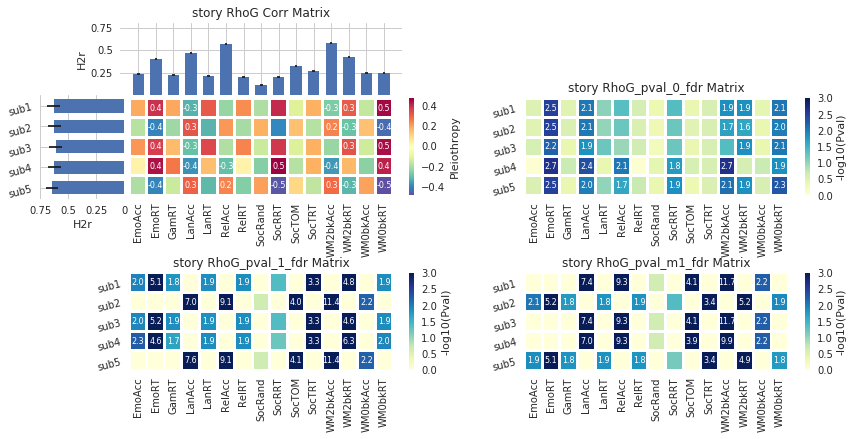

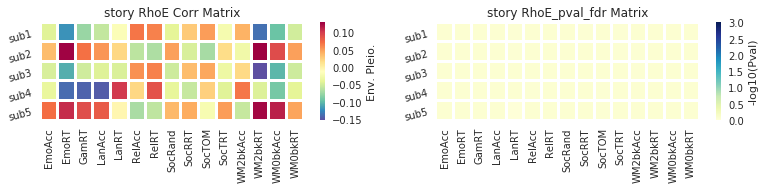

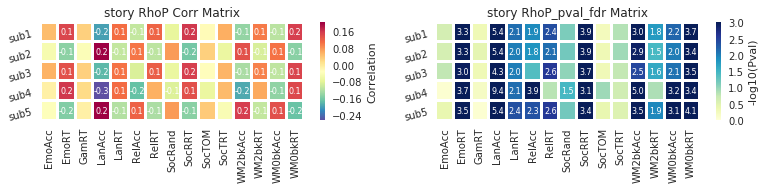

In [39]:
#Initiate no convergence result stack

path_pleio = os.path.join(path_root,'pleio_2019-07-24_language_tmp2')
No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'covar_1',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
H2r = dict()
count = 0
for ix_trial, trial in enumerate(list_trial):
    # initiate empty matrix
    RhoG = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_0 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_m1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
     
    # Loop over cluster
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name))
            
            # output result folder 
            out_dir = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            pedig_f = os.path.join(out_dir,pedig_file_ptrn.format(str.upper(task_name)))
            
            # pheno cov file
            pheno_f= os.path.join(out_dir,'pheno_cov.csv')
            # pedig file
            pedig_f = os.path.join(out_dir,'pleio_all_pheno_pedig.csv')
            
            #grab results from text file
            fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
            for i,line in enumerate(fp):
                if 'CONVERGENCE FAILURE' in line:
                    print(out_dir)
                    print(line)
                    count+=1
                    no_converges.append(No_converge(var_1 = pheno_1,
                                                    var_2 = pheno_2,
                                                    covar_1 = cov_1,
                                                    out_dir = out_dir,
                                                    pedig_f = pedig_f,
                                                    pheno_f = pedig_f))
                    break
                    
                    
                if 'H2r({}_norm) is '.format(pheno_1) in line:
                    H2r.update({'{}'.format(pheno_1):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_1) in line:
                    H2r['{}'.format(pheno_1)].update({'std':float(line.strip('\n').split(' ')[-1])})
                    
                if 'H2r({}_norm) is '.format(pheno_2) in line:
                    H2r.update({'{}'.format(subt):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_2) in line:
                    H2r['{}'.format(subt)].update({'std':float(line.strip('\n').split(' ')[-1])})

                if 'RhoE is ' in line:
                    RhoE[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[3])
                    RhoE_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoG is ' in line:
                    RhoG[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(out_dir)
                    #print(line.strip('\t ').strip('\n'))
                if 'RhoG different from zero' in line:
                    RhoG_pval_0[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(line.strip('\t '))
                if 'RhoG different from -1.0' in line:
                    RhoG_pval_m1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                elif 'RhoG different from 1.0' in line:
                    RhoG_pval_1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP is ' in line:
                    #print(float(line.strip('\n').split(' ')[-1]))
                    RhoP[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP different from zero' in line:
                    RhoP_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    #print(float(line.strip('\n').split(' ')[-1]))
                    break
    # save matrices
    all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                         'RhoE_pval':RhoE_pval,
                                         'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                         'RhoG':RhoG,
                                         'RhoG_pval_0':RhoG_pval_0,
                                         'RhoG_pval_0_fdr':fdr_transf(RhoG_pval_0),
                                         'RhoG_pval_1':RhoG_pval_1,
                                         'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                         'RhoG_pval_m1':RhoG_pval_m1,
                                         'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                         'RhoP':RhoP,
                                         'RhoP_pval':RhoP_pval,
                                         'RhoP_pval_fdr':fdr_transf(RhoP_pval),
                                         'H2r':H2r,
                                         'list_sbt' :list_sbt,
                                         'list_pheno':list_pheno_clust
                                        }})
    
    ## Plot and save all results

    # RhoG Figure
    f, axes = plt.subplots(2, 2,figsize = (13,5))
    f.subplots_adjust(hspace= .8)

    # Save h2r to csv
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['H2r'])[list_pheno_clust+list_sbt]
    resul_.rename(columns = dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'H2r')))

    # Get H2r of behavioral and subtypes
    h2r_subt_df = resul_[list_sbt] #Subtypes
    h2r_behav_df  = resul_.drop(list_sbt,axis=1) #Behavioral

    # plot subtype H2r horizontal bar plot
    sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'axes.spines.bottom': False,
                   'axes.spines.left': False,'axes.spines.right': False,'axes.spines.top': False,})
    ax1 =f.add_axes([0.03,0.6,0.09,0.29])
    y_pos1 = np.arange(len(list_sbt))[::-1]
    ax1.barh(y_pos1,-h2r_subt_df.loc['h2r'],xerr= h2r_subt_df.loc['std'],align ='center',height = 0.65)
    ax1.set_xticks([0,-.25,-.5,-.75,-1])
    ax1.set_xticklabels([0,.25,.5,.75,1])
    ax1.set_xlim(-0.75,0)
    ax1.set_xlabel('H2r')
    ax1.set_yticks(y_pos1)
    ax1.set_yticklabels(list_sbt, rotation=15)

    # plot behavioral H2r horizontal bar plot 
    ax2 =f.add_axes([0.115,0.889,0.302,0.2])
    y_pos2 = np.arange(len(h2r_behav_df.columns.values))
    ax2.bar(y_pos2,h2r_behav_df.loc['h2r'],xerr= h2r_behav_df.loc['std'],align ='center',width =0.65 )
    ax2.set_xticks(y_pos2)
    ax2.set_xticklabels([])
    ax2.set_yticks([0,.25,.5,.75,1])
    ax2.set_yticklabels(['',.25,.5,.75,1])
    ax2.set_ylim(0,0.8)
    ax2.set_ylabel('H2r')


    # save RhoG_pval_0_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

    # plot RhoG_pval_0_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[0][1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0][1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[0][1].set_yticklabels(list_sbt, rotation=15)
    axes[0][1].set_title('{} RhoG_pval_0_fdr Matrix'.format(trial),y=1.1)


    # Save RhoG to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
    # plot RhoG result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Pleiothropy"},linewidths=2,ax=axes[0][0])
    data = resul_.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[0][0].set_yticklabels(list_sbt, rotation=15)
    ax2.set_title('{} RhoG Corr Matrix'.format(trial),y=1.1)

    # save RhoG_pval_1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_1_fdr')))
    # plot RhoG_pval_1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][0],vmin=0,vmax=3)
    data = resul_.values
    for y in range(data.shape[0]):
        for x in range(data.shape[1]): 
            if data[y, x] >= 1.41:
                axes[1][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[1][0].set_yticklabels(list_sbt, rotation=15)
    axes[1][0].set_title('{} RhoG_pval_1_fdr Matrix'.format(trial),y=1.1)

    # save RhoG_pval_m1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_m1_fdr')))
    # plot RhoG_pval_m1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][1],vmin=0,vmax=3)
    data = resul_.values
    for y in range(data.shape[0]):
        for x in range(data.shape[1]): 
            if data[y, x] >= 1.41:
                axes[1][1].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[1][1].set_yticklabels(list_sbt, rotation=15)
    axes[1][1].set_title('{} RhoG_pval_m1_fdr Matrix'.format(trial),y=1.1)

    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))

    # RhoE figure
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoE_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

    # plot RhoE_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoE_pval_fdr Matrix'.format(trial),y=1.1)

    # save RhoE to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

    # plot RhoE result

    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env. Pleio."},linewidths=2,ax=axes[0])
    data = resul_.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoE Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

    # RhoP figure 
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoP_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

    # plot RhoP_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoP_pval_fdr Matrix'.format(trial),y=1.1)

    # save RhoP to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

    # plot RhoP result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Correlation"},linewidths=2,ax=axes[0])
    data = resul_.values
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoP Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))


# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)

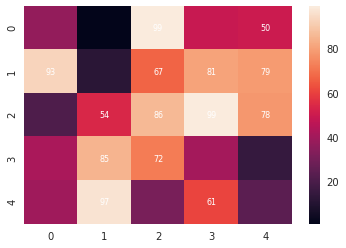

In [105]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

data = np.random.randint(100, size=(5,5))
ax = sns.heatmap(data)

# put labels manually
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 50:
            plt.text(x+0.5, y+.5, '%d' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
plt.show()